In [189]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd

from os import listdir, mkdir, getcwd
from os.path import isfile, join, basename, isdir

from sys import platform
#if platform == "linux" or platform == "linux2":
#    import ROOT
#    %jsroot off

from analysis.convert_directory import convert_directory

In [190]:
source_path = getcwd() # "/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/ZHH/"
output_path = join(source_path, ".npy")

convert_directory(source_path, "dataTree", output_path)

Skipping file <compare_out.root> (exists)


In [179]:
# Splits a dataframe with separate columns for reco and true properties to one with the properties and a different label "type" with values "true" and "reco" 
def split_event_tree(df,
                     properties=["sigma", "nll"],
                     props_shared=["run", "event", "true_is_zhh", "true_is_zzh", "true_h1z2_decay_pdg", "true_llr"],
                     type_names=["true_zhh", "true_zzh"], column_concat: str ="_"):
    #type_dict = {}
    #for property in properties:
    #    type_dict[property] = pd.Series(dtype=df.dtypes[type_names[0] + column_concat + property])

    # Rename
    rename_dict = {}
    for property in properties:
        rename_dict[type_names[0] + column_concat + property] = property

    df = df.rename(columns=rename_dict)
    df["type"] = type_names[0]

    # Slice and re-add
    for type in type_names:
        if type == type_names[0]:
            continue

        #column_names = [word.replace(type + column_concat, "") for word in ["asd_123", "asd_345"]]
        props_type_specific = list(map(lambda cn: type+column_concat+cn, properties))
        props_slice = props_shared + props_type_specific
        sliced = df.loc[:, props_slice]

        df.drop(columns=props_type_specific, inplace=True)

        rename_dict = {}
        for property in properties:
            rename_dict[type + column_concat + property] = property

        sliced.rename(columns=rename_dict, inplace=True)
        sliced["type"] = type

        df = pd.concat([df, sliced])

    df.reset_index(drop=True, inplace=True)

    return df

def type_column(df, column="type", types = ["true_zhh", "true_zzh"], check = ["true_is_zhh", "true_is_zzh"]):
    col = []

    for i in range(0, len(df)):
        col.append("none")
        for j in range(0, len(check)):
            if df[check[j]][i]:
                col[i] = types[j]
                break
    
    df[column] = col

    return df

In [151]:
b = list(map(lambda e: join(output_path, e), listdir(output_path)))
b

['c:\\DevRepositories\\MEM_HEP\\.npy\\compare_out.root.npy']

In [205]:
data = pd.DataFrame(np.load(b[0], allow_pickle=True))
data.columns

Index(['run', 'event', 'true_is_zhh', 'true_is_zzh', 'true_h1_decay_pdg',
       'true_z2_decay_pdg', 'true_zhh_sigma', 'true_zhh_sigmall',
       'true_zhh_sigmalr', 'true_zhh_sigmarl', 'true_zhh_sigmarr',
       'true_zhh_mz', 'true_zhh_mhh', 'true_zhh_mzhh', 'true_zhh_phi',
       'true_zhh_phif', 'true_zhh_phih', 'true_zhh_costheta',
       'true_zhh_costhetaf', 'true_zhh_costhetah', 'true_zhh_l1_e',
       'true_zhh_l1_px', 'true_zhh_l1_py', 'true_zhh_l1_pz', 'true_zhh_l2_e',
       'true_zhh_l2_px', 'true_zhh_l2_py', 'true_zhh_l2_pz', 'true_zhh_h1_e',
       'true_zhh_h1_px', 'true_zhh_h1_py', 'true_zhh_h1_pz', 'true_zhh_h2_e',
       'true_zhh_h2_px', 'true_zhh_h2_py', 'true_zhh_h2_pz', 'true_zzh_sigma',
       'true_zzh_sigmalll', 'true_zzh_sigmallr', 'true_zzh_sigmalrl',
       'true_zzh_sigmalrr', 'true_zzh_sigmarrr', 'true_zzh_sigmarrl',
       'true_zzh_sigmarlr', 'true_zzh_sigmarll', 'true_zzh_mz1',
       'true_zzh_mz2', 'true_zzh_mzz', 'true_zzh_mzzh', 'true_zzh_phi',
  

In [206]:
data.dtypes

run                    int32
event                  int32
true_is_zhh            int32
true_is_zzh            int32
true_h1_decay_pdg      int32
                      ...   
true_zzh_z2f2_pz     float64
true_zzh_h_e         float64
true_zzh_h_px        float64
true_zzh_h_py        float64
true_zzh_h_pz        float64
Length: 77, dtype: object

In [207]:
data["true_h1z2_decay_pdg"] = data["true_h1_decay_pdg"] + data["true_z2_decay_pdg"]

Text(0.5, 1.0, 'PDGs before cut')

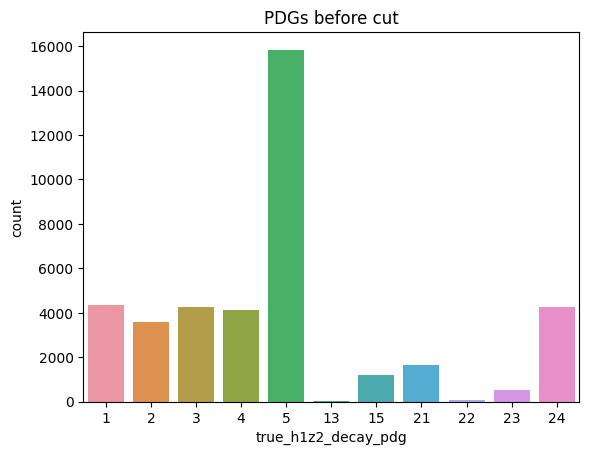

In [208]:
ax = sns.countplot(data, x="true_h1z2_decay_pdg")
ax.set_title("PDGs before cut")

Important: Unaccounted/"thrown away" events: H->gg,gammagamma,ZZ,W+W-

In [209]:
# Show amount of thrown-away entries
selection = data[(data["true_zhh_sigma"] <= 0) | (data["true_zzh_sigma"] <= 0)]
print("Throwing away", len(selection)/len(data)*100, "% of all events")

Throwing away 16.28391959798995 % of all events


In [210]:
# Applying cut
data_cut = data.loc[(data["true_zhh_sigma"] > 0) & (data["true_zzh_sigma"] > 0)].copy()
data_cut.shape

(33319, 78)

Text(0.5, 1.0, 'PDGs after cut')

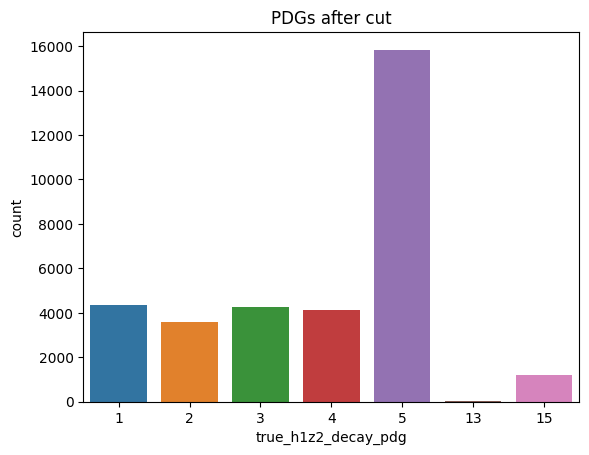

In [211]:
ax = sns.countplot(data_cut, x="true_h1z2_decay_pdg")
ax.set_title("PDGs after cut")

In [212]:
data_cut["true_zhh_nll"] = np.log(data_cut["true_zhh_sigma"])
data_cut["true_zzh_nll"] = np.log(data_cut["true_zzh_sigma"])
data_cut["true_llr"]     = np.log(data_cut["true_zzh_sigma"]/data_cut["true_zhh_sigma"])
data_cut.reset_index(drop=True, inplace=True)

In [213]:
type_column(data_cut, column="true_type")

,run,event,true_is_zhh,true_is_zzh,true_h1_decay_pdg,true_z2_decay_pdg,true_zhh_sigma,true_zhh_sigmall,true_zhh_sigmalr,true_zhh_sigmarl,...,true_zzh_z2f2_pz,true_zzh_h_e,true_zzh_h_px,true_zzh_h_py,true_zzh_h_pz,true_h1z2_decay_pdg,true_zhh_nll,true_zzh_nll,true_llr,true_type
0,403011,1,0,1,0,3,7.344602e-14,6.965651e-14,3.789516e-15,3.805584e-15,...,124.031075,157.041733,72.794846,-53.599247,-29.413172,3,-30.242226,-42.883269,-12.641044,true_zzh
1,403011,2,0,1,0,3,4.030331e-15,3.575435e-15,4.548957e-16,4.571881e-16,...,11.577676,207.198273,-61.250061,-57.741375,142.198761,3,-33.144928,-46.555974,-13.411046,true_zzh
2,403011,3,0,1,0,4,5.704280e-14,2.816861e-14,2.887418e-14,2.887788e-14,...,0.089793,131.937668,35.247631,13.085950,19.206999,4,-30.494975,-39.832370,-9.337396,true_zzh
3,403011,4,0,1,0,4,5.946260e-15,1.461537e-15,4.484724e-15,4.473190e-15,...,-30.268082,220.370789,23.868135,-177.702896,-28.111895,4,-32.756014,-43.984598,-11.228584,true_zzh
4,403011,5,0,1,0,5,1.256231e-14,1.136108e-14,1.201230e-15,1.202365e-15,...,61.523773,139.716232,12.830882,56.313324,-23.660160,5,-32.008075,-48.242983,-16.234907,true_zzh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33314,403001,19895,1,0,5,0,2.022659e-14,1.624323e-14,3.983353e-15,3.990611e-15,...,44.087395,156.972397,-77.503944,-53.362381,-12.685842,5,-31.531779,-48.381342,-16.849563,true_zhh
33315,403001,19896,1,0,5,0,3.631795e-14,6.018618e-15,3.029933e-14,3.025981e-14,...,71.241051,168.075668,-6.780193,97.447922,-55.519016,5,-30.946464,-48.879893,-17.933429,true_zhh
33316,403001,19898,1,0,5,0,8.335609e-14,4.747340e-15,7.860875e-14,7.863524e-14,...,28.491776,178.257095,-72.755600,-69.548782,77.589828,5,-30.115655,-47.655458,-17.539803,true_zhh
33317,403001,19899,1,0,5,0,4.213894e-14,4.425577e-15,3.771336e-14,3.769419e-14,...,-23.244761,213.940765,115.845673,129.089935,-7.824111,5,-30.797804,-48.472920,-17.675116,true_zhh


Text(0.5, 0, 'ln(L_0/L_1)')

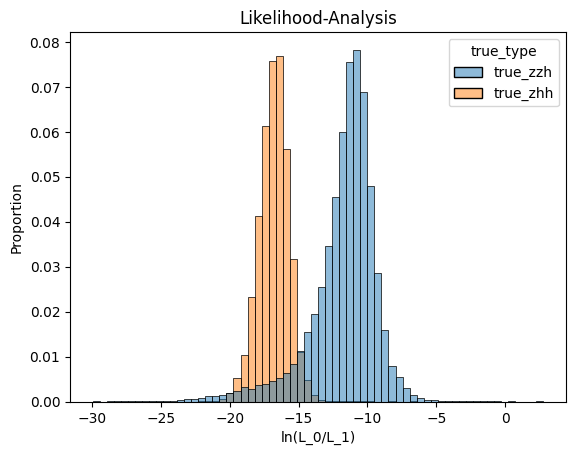

In [214]:
ax = sns.histplot(data_cut, x="true_llr", hue="true_type", bins=64, stat="proportion")
ax.set_title("Likelihood-Analysis")
ax.set_xlabel("ln(L_0/L_1)")

In [134]:
true_zhh = data_cut[data_cut["true_is_zhh"] == 1]
true_zzh = data_cut[data_cut["true_is_zzh"] == 1]

In [201]:
print(true_zhh.shape[0], true_zzh.shape[0])

13419 19900


In [136]:
true_zhh_split = split_event_tree(true_zhh)
true_zzh_split = split_event_tree(true_zzh)

Text(0.5, 1.0, 'True ZHH MCParticles')

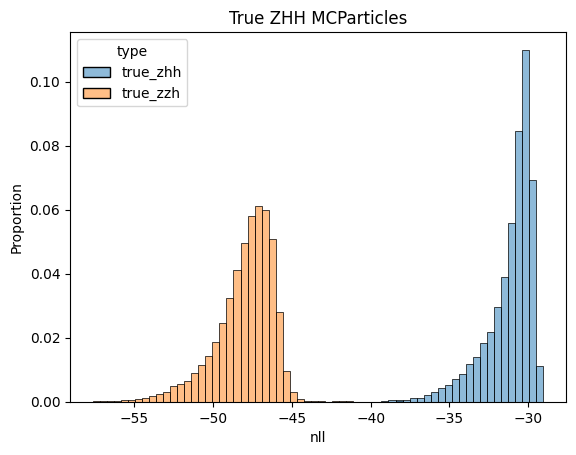

In [197]:
ax = sns.histplot(true_zhh_split, x="nll", hue="type", bins=64, stat="proportion")
ax.set_title("True ZHH MCParticles")

In [204]:
true_zzh_split.reset_index(drop=True, inplace=True)
true_zzh_split

,run,event,true_is_zhh,true_is_zzh,true_h1_decay_pdg,true_z2_decay_pdg,sigma,true_zhh_sigmall,true_zhh_sigmalr,true_zhh_sigmarl,...,true_zzh_z2f2_py,true_zzh_z2f2_pz,true_zzh_h_e,true_zzh_h_px,true_zzh_h_py,true_zzh_h_pz,true_h1z2_decay_pdg,nll,true_llr,type
0,403011,1,0,1,0.0,3.0,7.344602e-14,6.965651e-14,3.789516e-15,3.805584e-15,...,46.695015,124.031075,157.041733,72.794846,-53.599247,-29.413172,3,-30.242226,-12.641044,true_zhh
1,403011,2,0,1,0.0,3.0,4.030331e-15,3.575435e-15,4.548957e-16,4.571881e-16,...,-12.769003,11.577676,207.198273,-61.250061,-57.741375,142.198761,3,-33.144928,-13.411046,true_zhh
2,403011,3,0,1,0.0,4.0,5.704280e-14,2.816861e-14,2.887418e-14,2.887788e-14,...,-27.447758,0.089793,131.937668,35.247631,13.085950,19.206999,4,-30.494975,-9.337396,true_zhh
3,403011,4,0,1,0.0,4.0,5.946260e-15,1.461537e-15,4.484724e-15,4.473190e-15,...,32.319328,-30.268082,220.370789,23.868135,-177.702896,-28.111895,4,-32.756014,-11.228584,true_zhh
4,403011,5,0,1,0.0,5.0,1.256231e-14,1.136108e-14,1.201230e-15,1.202365e-15,...,-85.247139,61.523773,139.716232,12.830882,56.313324,-23.660160,5,-32.008075,-16.234907,true_zhh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39795,403011,19896,0,1,NaN,NaN,2.275090e-18,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5,-40.624512,-10.832258,true_zzh
39796,403011,19897,0,1,NaN,NaN,6.323993e-20,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,-44.207351,-11.126942,true_zzh
39797,403011,19898,0,1,NaN,NaN,2.782756e-22,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,-49.633430,-10.867312,true_zzh
39798,403011,19899,0,1,NaN,NaN,6.431234e-19,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,-41.887950,-11.220890,true_zzh


Text(0.5, 1.0, 'True ZZH MCParticles')

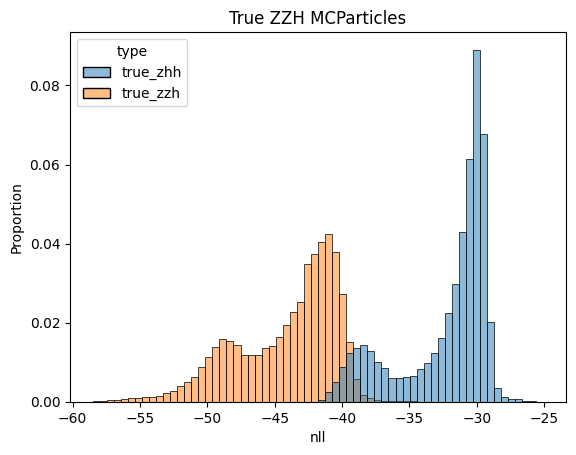

In [198]:
ax = sns.histplot(true_zzh_split, x="nll", hue="type", bins=64, stat="proportion")
ax.set_title("True ZZH MCParticles")